In [66]:
import pandas as pd

In [130]:
df = pd.read_csv("./data/train.csv")

In [68]:
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [69]:
# Feature	Description
# id	Customer ID
# Gender	Male/Female
# Age	Customer age
# Driving_License	1 if they have a DL, else 0
# Previously_Insured	1 if they already have health insurance
# Vehicle_Age	How old is the vehicle (e.g., >2 Years, 1-2 Year, <1 Year)
# Vehicle_Damage	Was vehicle damaged before? (Yes/No)
# Annual_Premium	Insurance cost paid yearly
# Policy_Sales_Channel	Channel through which policy was sold (e.g., agent, call center)
# Vintage	How many days since the customer joined
# Response	Target variable (0 = no interest, 1 = interested)

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


In [71]:
df.describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,190555.000000,38.822584,0.997869,26.388807,0.458210,30564.389581,112.034295,154.347397,0.122563
std,110016.836208,15.511611,0.046110,13.229888,0.498251,17213.155057,54.203995,83.671304,0.327936
min,1.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,95278.000000,25.000000,1.000000,15.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,190555.000000,36.000000,1.000000,28.000000,0.000000,31669.000000,133.000000,154.000000,0.000000
75%,285832.000000,49.000000,1.000000,35.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,381109.000000,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


In [72]:
df.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

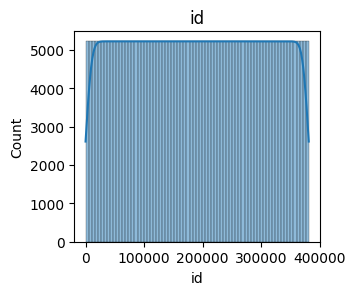

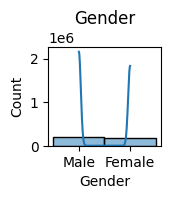

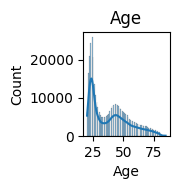

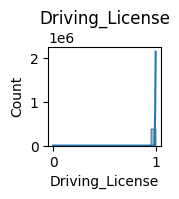

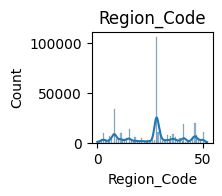

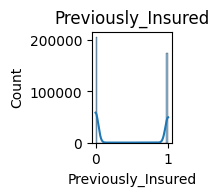

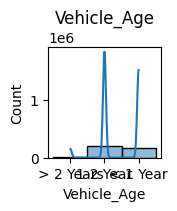

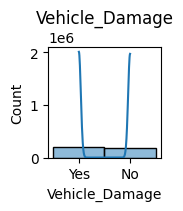

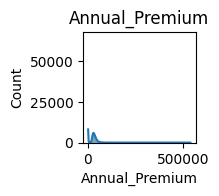

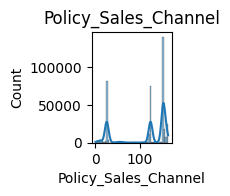

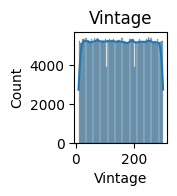

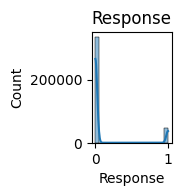

In [73]:
# check the distribution of the all the variables 

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 8))
for i, column in enumerate(df.columns):
    plt.subplot(3, 4, i + 1)
    sns.histplot(df[column], kde=True)
    plt.title(column)
    plt.tight_layout()
    plt.show()

<Axes: title={'center': 'Response Distribution'}, xlabel='Response'>

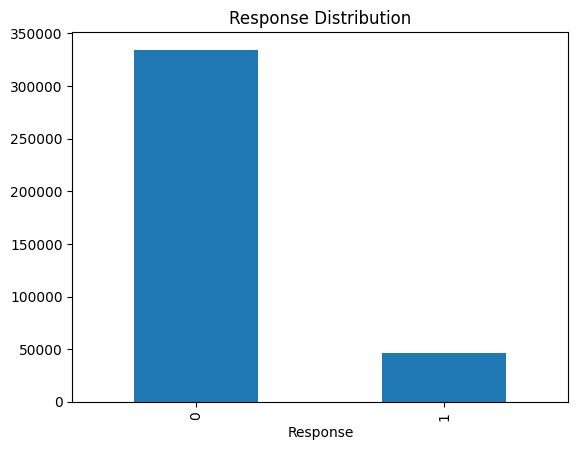

In [74]:
df['Response'].value_counts().plot(kind='bar', title='Response Distribution')

In [110]:
# check the distribution of the categorical variables
for col in categorical:
    print(f"Value counts for {col}:")
    print(df[col].value_counts())
    print()

Value counts for Vehicle_Damage:
Vehicle_Damage
Yes    192413
No     188696
Name: count, dtype: int64

Value counts for Previously_Insured:
Previously_Insured
0    206481
1    174628
Name: count, dtype: int64

Value counts for Vehicle_Age:
Vehicle_Age
1-2 Year     200316
< 1 Year     164786
> 2 Years     16007
Name: count, dtype: int64



In [136]:
# check the distribution of the numerical variable

for col in numerical:
    print(f"Value counts for {col}:")
    print(df[col].value_counts())    

Value counts for Policy_Sales_Channel:
Policy_Sales_Channel
152.0    134784
26.0      79700
124.0     73995
160.0     21779
156.0     10661
          ...  
149.0         1
43.0          1
144.0         1
143.0         1
41.0          1
Name: count, Length: 155, dtype: int64


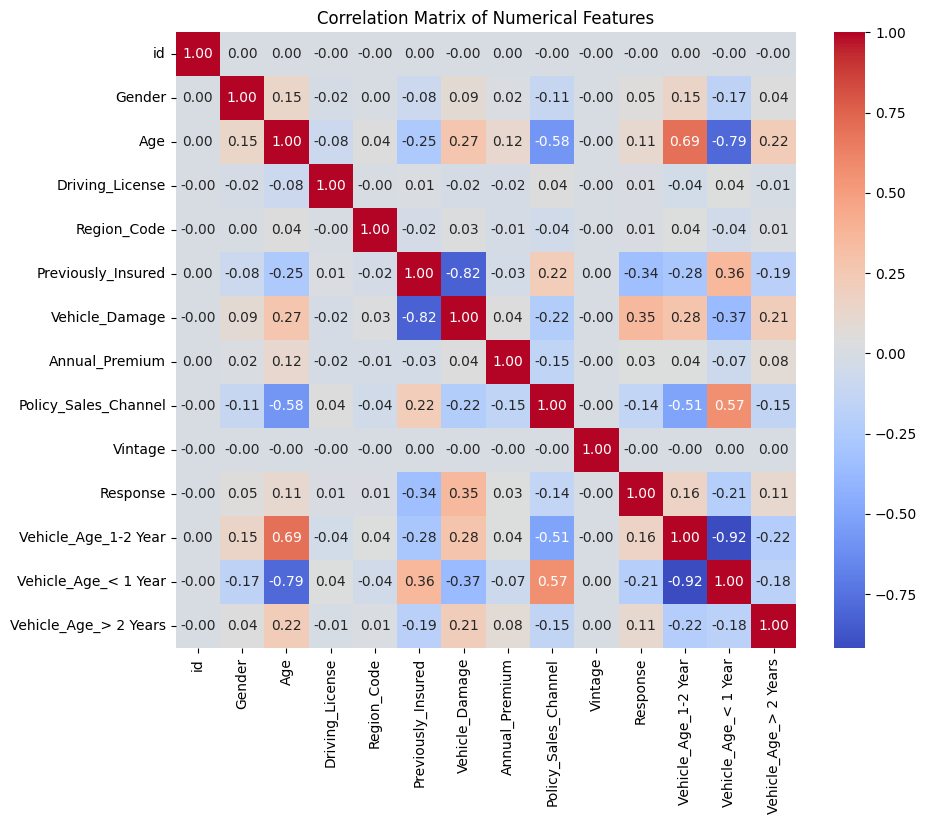

In [89]:
#  check the correlation between the numerical features
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f') 
plt.title('Correlation Matrix of Numerical Features')
plt.show()


In [104]:
# choose the categorical and numerical features

categorical = ['Vehicle_Damage' , 'Previously_Insured', 'Vehicle_Age']

numerical = ['Policy_Sales_Channel']

In [131]:
# use label encoding for categorical features
from sklearn.preprocessing import LabelEncoder

vehicle_age_map = {
    "1-2 Year": 0,
    "< 1 Year": 1,
    "> 2 Years": 2
}
df["Vehicle_Age"] = df["Vehicle_Age"].map(vehicle_age_map)

le = LabelEncoder()
for col in categorical:
    if col != 'Vehicle_Age' :
        df[col] = le.fit_transform(df[col])


In [137]:
# Standardize the numerical features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[numerical] = scaler.fit_transform(df[numerical])


In [ ]:
# train the model 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


X = df[categorical + numerical ]
y = df['Response']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# evaluate the model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = rf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))



Classification Report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.93     66699
           1       0.31      0.00      0.00      9523

    accuracy                           0.87     76222
   macro avg       0.59      0.50      0.47     76222
weighted avg       0.80      0.87      0.82     76222



In [141]:
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.8749180026763926
